# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.charge_flip_calc import charge_flip_calc
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive
import time

In [4]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = False
local = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'charge_flip_calc'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2016

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples()

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'TTZ', 'top',], samples, redirector=redirector_ucsd, small=False)
#add back in:  

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

#meta = get_sample_meta(fileset, samples)

chunksize = 25000

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress
    
    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)
    
    def unique(filename):
        file, ext = os.path.splitext(filename)
        counter = 0
        while os.path.exists(filename):
            counter += 1
            filename = file + str(counter) + ext
        return filename

    tstart = time.time()
    
    from dask.distributed import performance_report
    fname = unique("dask-report_chunksize=" + str(chunksize/1000) + "K.html")
    
    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
        'savemetrics': True
    }
    exe = processor.dask_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    #with performance_report(filename=fname):
    output = processor.run_uproot_job(
        fileset,
        "Events",
        charge_flip_calc(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=chunksize,
        )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

NameError: name 'num' is not defined

In [ ]:
import cloudpickle
import gzip
dt = time.time() - tstart
outname = 'charge_calc'
os.system("mkdir -p histos/")
print('Saving output in %s...'%("histos/" + outname + ".pkl.gz"))
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(output, fout)
print('Done!')
print("Events / s / thread: {:,.0f}".format(output[1]['entries'].value / output[1]['processtime'].value))
print("Events / s: {:,.0f}".format(output[1]['entries'].value / dt))

In [ ]:
output[1].keys(), output[1]['processtime'].value

In [4]:
output['totalEvents']['all']/1e6

1.208

Full fileset is 180M events, and that's basically just DY and ttbar.

In [9]:
# import the plotting libararies: matplotlib and mplhep
from Tools.nano_mapping import make_fileset, nano_mapping
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
eta_bins       = hist.Bin('eta', r'$\eta $', np.array([0, 0.8, 1.479, 2.5]))
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

my_labels = {
    nano_mapping['TTW'][0]: 'ttW',
    nano_mapping['TTZ'][0]: 'ttZ',
    nano_mapping['DY'][0]: 'DY',
    nano_mapping['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mapping['TTW'][0]: '#8AC926',
    nano_mapping['TTZ'][0]: '#FFCA3A',
    nano_mapping['DY'][0]: '#6A4C93',
    nano_mapping['top'][0]: '#1982C4',
}



# 1D Histograms

26635.304508297282
Data: 0 MC: 29520.82


KeyError: ()

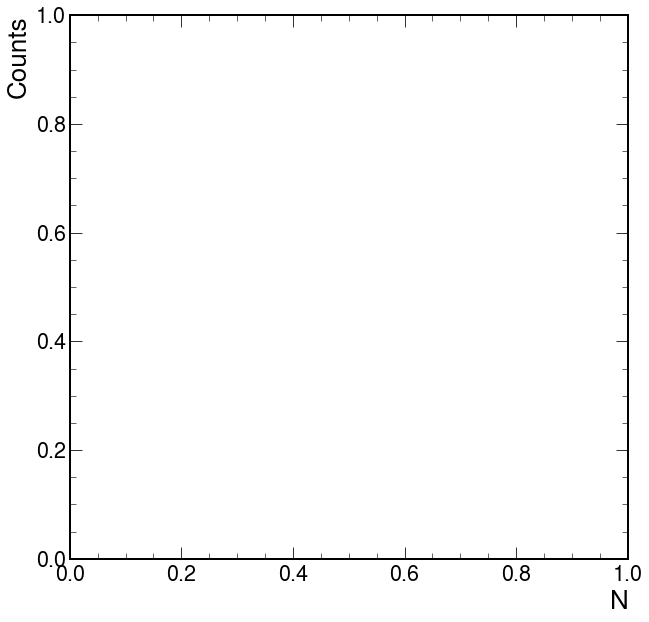

In [6]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_ele'], samples, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_test_'+str(year)
        )


65395690.098985076
Data: 0 MC: 65416753.1


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/N_ele_flips_test_2018


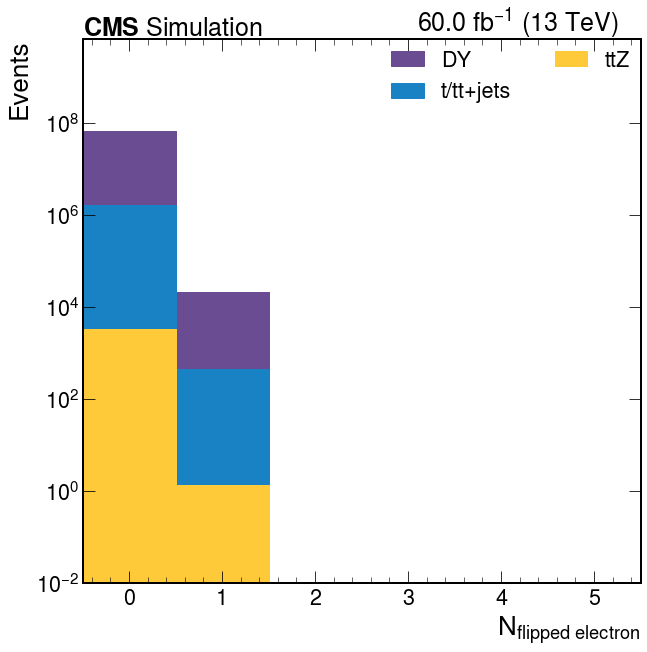

In [63]:
my_hist = scale_and_merge(output['electron_flips'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_flips_test_'+str(year)
        )

61919790.682529345
Data: 0 MC: 84146298.77


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/electron_pt_test_2018


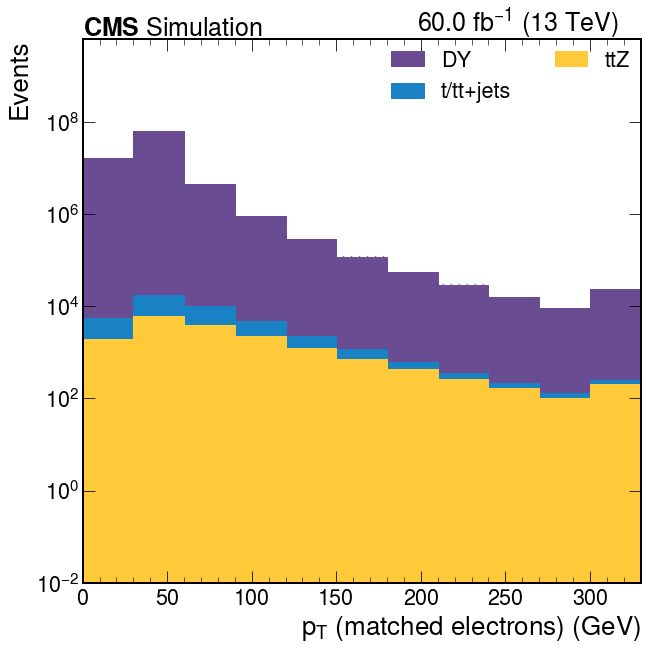

In [64]:
my_hist = scale_and_merge(output["electron"], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (matched\ electrons)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/electron_pt_test_'+str(year)
        )

15264.604643796245
Data: 0 MC: 20624.0


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/flipped_electron_pt_test_2018


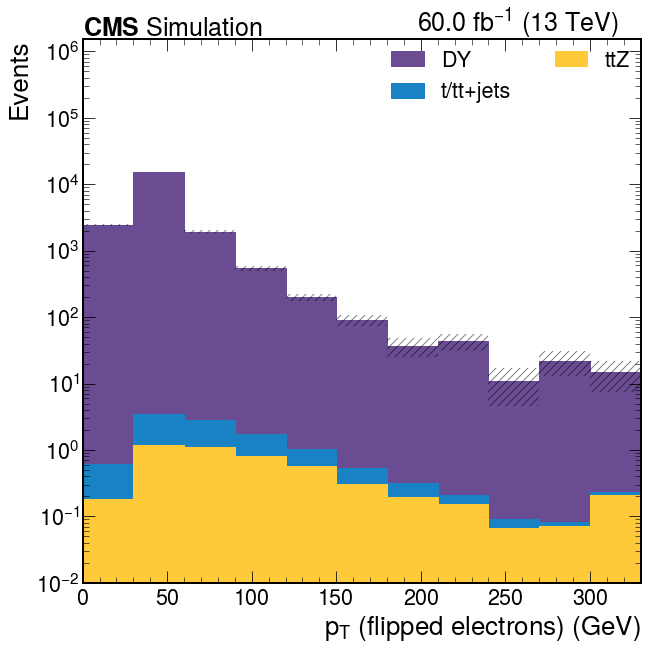

In [65]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
        bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (flipped\ electrons)\ (GeV)$',
        new_colors=my_colors, new_labels=my_labels,
        order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        save=os.path.expandvars(cfg['meta']['plots'])+'histos/flipped_electron_pt_test_'+str(year)
        )

22139187.59832892
Data: 0 MC: 84144689.38


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/electron_eta_test_2018


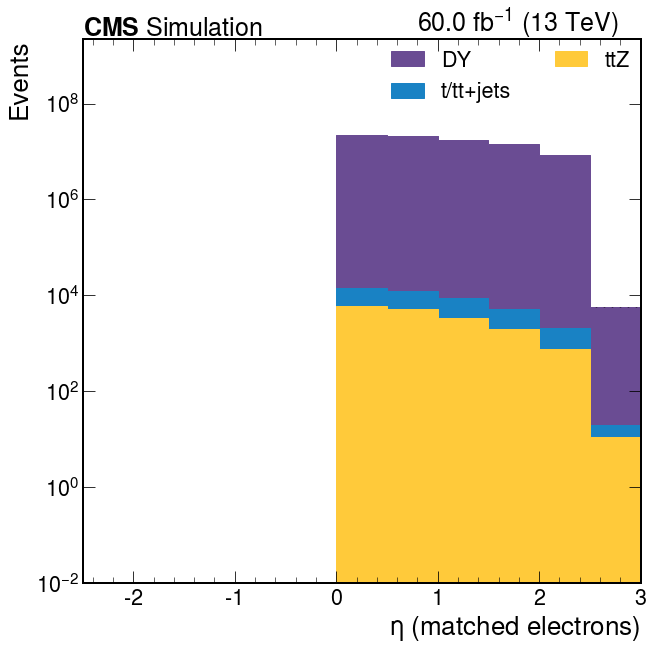

In [66]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (matched\ electrons)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/electron_eta_test_'+str(year)
        )

8849.767208735238
Data: 0 MC: 20624.0


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/flipped_electron_eta_test_2018


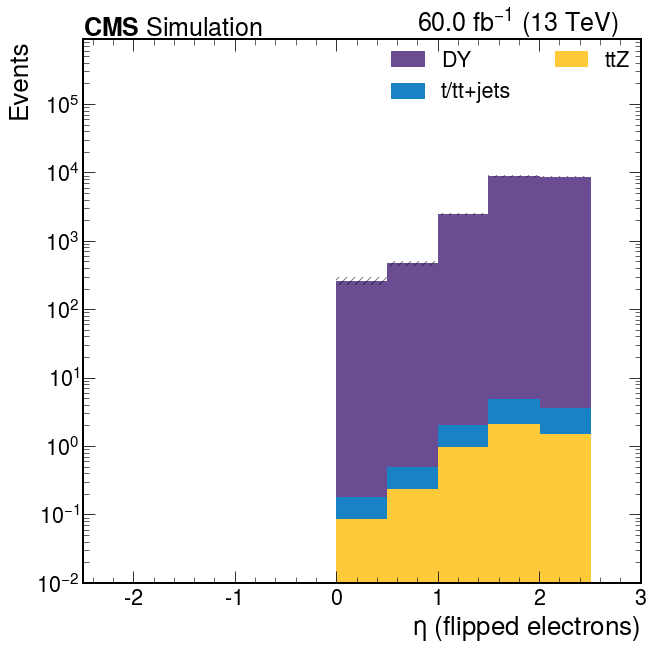

In [67]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (flipped\ electrons)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/flipped_electron_eta_test_'+str(year)
        )

# 2D Histograms

In [7]:
from yahist import Hist1D, Hist2D
import numpy as np

In [10]:
tmp3 = output['flipped_electron'].copy()
tmp3 = tmp3.rebin('eta', eta_bins)
tmp3 = tmp3.rebin('pt', pt_bins)


tmp4 = output['electron'].copy()
tmp4 = tmp4.rebin('eta', eta_bins)
tmp4 = tmp4.rebin('pt', pt_bins)

h3 = Hist2D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),
)


h4 = Hist2D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),
)

In [11]:
h5 = h3.divide(h4, binomial=True)

In [12]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Further stolen from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, errors=None, size=8, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Further stolen from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    show_errors = (type(errors) != type(None))
    print(show_errors)
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2
    
    if show_errors:
        label_template = r"{0"+fmt+"}\n$\pm{1:f}\%$"
        print(label_template)
    else:
        errors = np.zeros(counts.shape)
        label_template = r"{0"+fmt+"}"
        
    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
        errors.flatten()
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, count, err), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            label_template.format(count, err),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

In [13]:
h5.errors

array([[2.49049127e-05, 3.41695206e-05, 4.23663285e-05,            nan,
                   nan,            nan],
       [5.77768886e-05, 1.00453813e-04, 1.01624997e-04, 2.30252660e-04,
        1.65117852e-04,            nan],
       [1.89819202e-04, 2.18447018e-04, 3.64213943e-04, 5.42717163e-04,
        5.84129074e-04, 4.38991860e-03]])

True
{0:g}
$\pm{1:f}\%$


Text(0, 1, '$\\eta$')

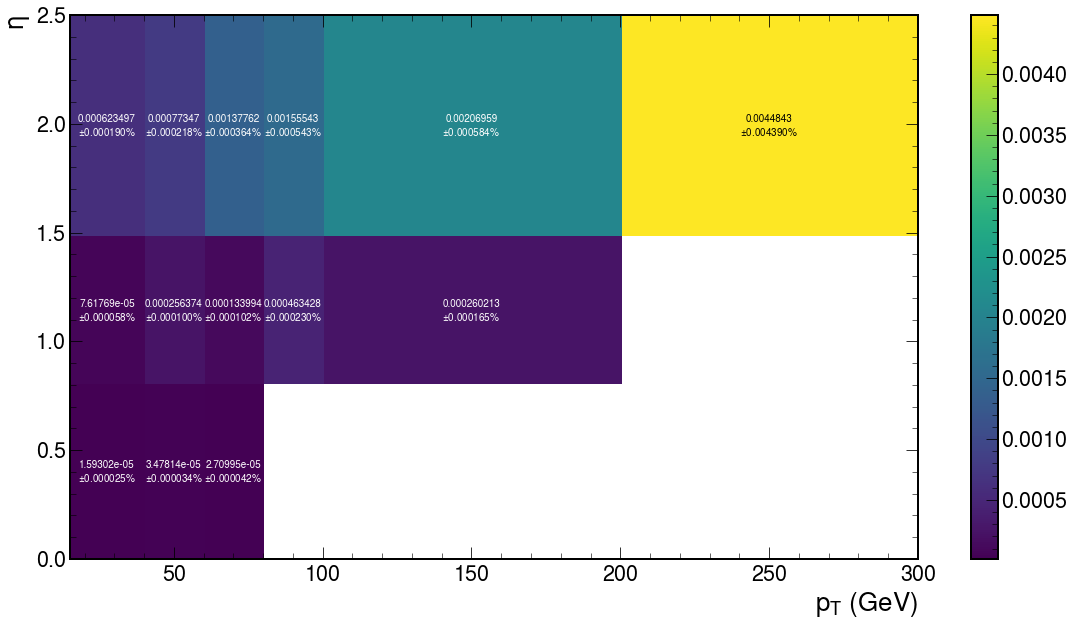

In [14]:
fig, ax  = plt.subplots(1, 1,figsize=(19,10) )
bin_text(h5.counts, h5._edges[0], h5._edges[1], ax, cbar=fig.colorbar(h5.plot(colorbar=False)[0], ax=ax), errors = h5.errors, size = 10)
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

Text(0, 1, '$\\eta$')

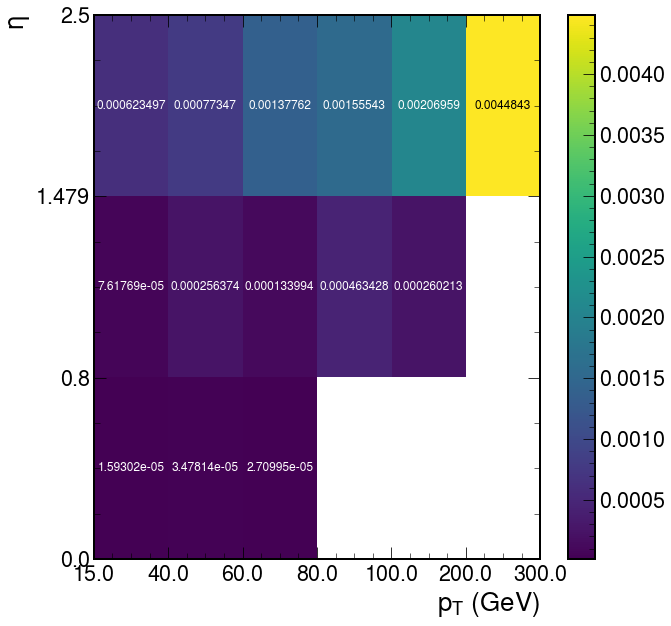

In [17]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h5.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

Text(0, 1, '$\\eta$')

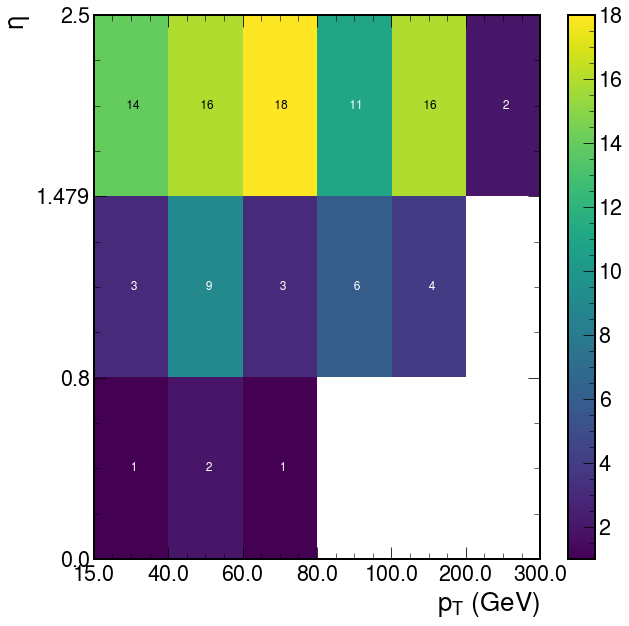

In [15]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h3.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

Text(0, 1, '$\\eta$')

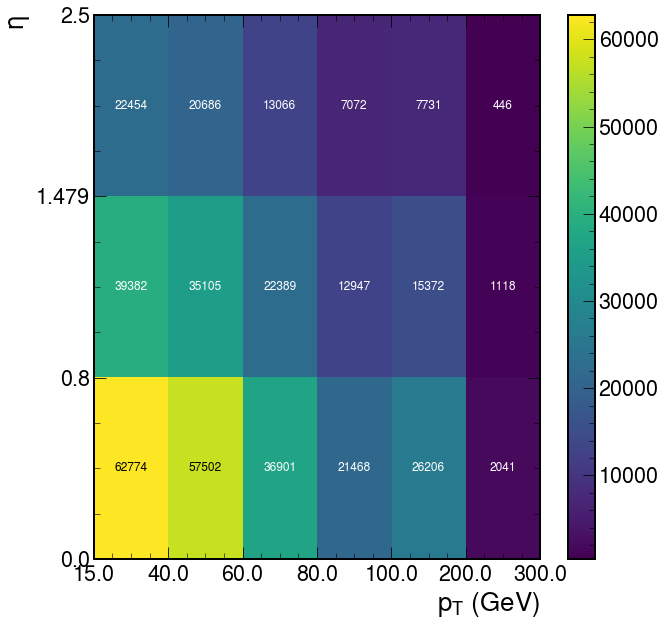

In [16]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h4.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

In [ ]:
import cloudpickle
import gzip

outname = 'chargeflipfullfixed3'
os.system("mkdir -p histos/")
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(h3.divide(h4, binomial=True), fout)
print('Saving histo in %s...'%("histos/" + outname + ".pkl.gz"))

In [ ]:
import gzip
import pickle
path = 'histos/chargeflipfullfixed3.pkl.gz'
with gzip.open(path) as fin:
            ratio= pickle.load(fin)

In [ ]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
ratio.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')